In [1]:
from skimage import io, transform, color
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image
import os
import math
import torchvision.models as models

from dataLoader import OrganoidDataset
#from conv_model import SimpleConvNet
import matplotlib.pyplot as plt
import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

figure_path = '../milestoneReport/figures/'
#path = '../data/CS231n_Tim_Shan_example_data/'
path = '../data/'
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

## load data 

In [3]:
#indexes=[]
class OrganoidMultipleDataset(data.Dataset):
    'dataset class for microwell organoid images'
    def __init__(self, path2files, image_names, Y, mean_sd_dict, transforms=None):
        for k, image_name in image_names.items():
            assert len(image_name) == len(Y)
        self.path = path2files
        self.image_names = image_names
        self.Y = Y
        self.mean_sd_dict = mean_sd_dict
        self.transforms = transforms
    def __len__(self):
        return len(self.Y)
    def getXimage(self, index):
        all_images_list = []
        for day,img_names in self.image_names.items():
            #print(day, "   ", index)
            img_name = img_names[index]
            img_loc = os.path.join(self.path, img_name)
            image = io.imread(img_loc)
            mean, sd = self.mean_sd_dict[day]
            image = np.true_divide(color.rgb2gray(image) - mean, sd)
            all_images_list.append(image)
        images = np.array(all_images_list)
        return torch.from_numpy(images).float()
    def getY(self, index):
       
        Y = torch.from_numpy(np.asarray(self.Y[index], dtype=float)).float()

        return Y.view(-1)
    def __getitem__(self, index):
        X = self.getXimage(index)
        y = self.getY(index)
        if self.transforms is not None:
            X = self.transforms(X)
        #indexes.append(index)
        return X, y

In [4]:
# training_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_train_v2.csv')
# validation_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_validation_v2.csv')
# test_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_test_v2.csv')

In [102]:
training_labels = pd.read_csv('../data_description/A1_A2_A3_A4_C1_C2_filtered_train_v2.csv')
validation_labels = pd.read_csv('../data_description/A1_A2_A3_A4_C1_C2_filtered_validation_v2.csv')

#### filter for predict size

In [103]:
training_labels = training_labels.query('has_cell_13 == 1').reset_index()
validation_labels = validation_labels.query('has_cell_13 == 1').reset_index()
#test_labels = test_labels.query('has_cell_13 == 1').reset_index()

In [104]:
training_labels.shape,validation_labels.shape,test_labels.shape

((7372, 61), (913, 61), (478, 62))

In [105]:
NUM_TRAIN = training_labels.shape[0]
NUM_VAL = validation_labels.shape[0]

In [106]:
NUM_TRAIN,NUM_VAL

(7372, 913)

In [107]:
training_labels.head(2)

,index,Unnamed: 0,condition,well_id,day_0,well_label,image_name_0,has_cell_0,hyst2_area_0,day_1,...,has_cell_11,hyst2_area_11,day_12,image_name_12,has_cell_12,hyst2_area_12,day_13,image_name_13,has_cell_13,hyst2_area_13
0,1,1,C1,3108,0,3108,well_C1/well3108_day00_well.png,1,49,1,...,1,107,12,well_C1/well3108_day12_well.png,1,72,13,well_C1/well3108_day13_well.png,1,515
1,2,2,A2,64,0,64,well_A2/well0064_day00_well.png,1,1528,1,...,1,2807,12,well_A2/well0064_day12_well.png,1,1562,13,well_A2/well0064_day13_well.png,1,1316


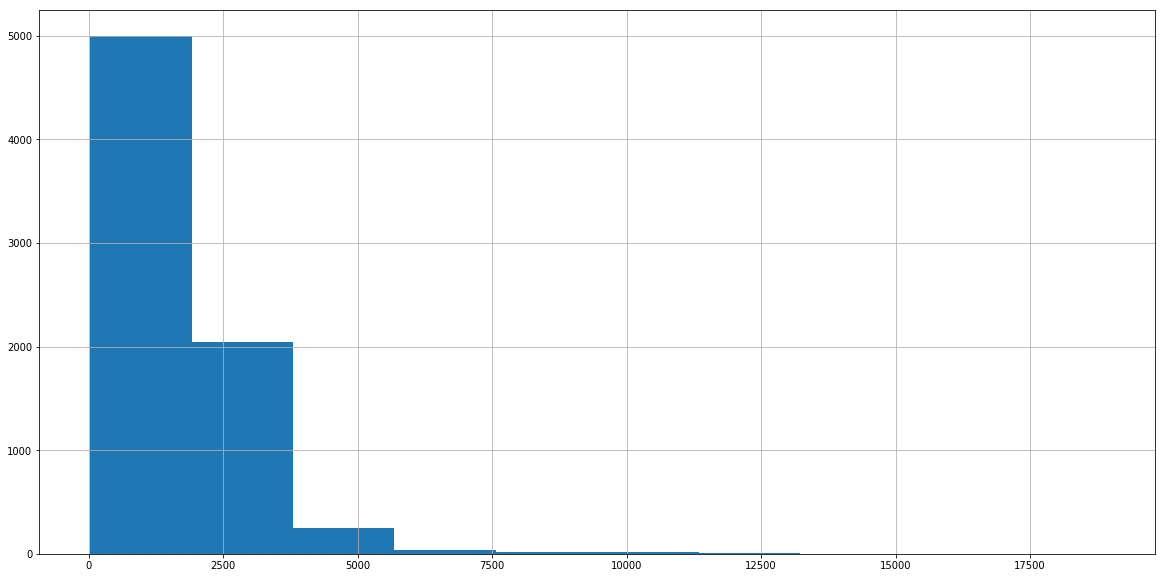

In [108]:
training_labels['hyst2_area_13'].hist()

In [109]:
training_labels['hyst2_area_13'].sort_values()

7058       25
1228       25
6587       25
5973       25
5318       25
3103       25
1102       25
5467       25
5925       25
5336       25
3050       25
4900       25
4255       25
1006       25
5867       25
3842       25
5427       25
898        25
2933       25
6777       25
823        25
4780       25
7125       25
3929       25
775        25
3977       25
1281       25
7207       25
4477       25
2724       25
        ...  
1876     9132
1343     9614
7076     9747
7262     9758
3208     9758
828      9896
4961     9934
7202     9964
1525    10134
6954    10151
4681    10171
30      10467
2963    10683
872     10725
4110    10745
1267    10961
1295    11126
2309    11211
6671    11266
835     11320
744     11329
4216    11428
124     11445
6488    11485
5033    11508
5157    11546
4270    11798
7010    11931
6470    12225
917     18885
Name: hyst2_area_13, Length: 7372, dtype: int64

In [110]:
y_mean =  training_labels['hyst2_area_13'].mean()
y_std = training_labels['hyst2_area_13'].std()

In [111]:
y_mean, y_std

(1448.4688008681499, 1454.535899589342)

In [112]:
training_labels['normalized_hyst2_area_13'] = (training_labels['hyst2_area_13'] - y_mean)/y_std
validation_labels['normalized_hyst2_area_13'] = (validation_labels['hyst2_area_13'] - y_mean)/y_std

In [113]:
training_image_names = {2:training_labels['image_name_2'],8:training_labels['image_name_8'], 5:training_labels['image_name_5']}
validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8'],5:validation_labels['image_name_5']}

In [114]:
training_y = training_labels['normalized_hyst2_area_13']
validation_y = validation_labels['normalized_hyst2_area_13']
#test_y = test_labels['hyst2_area_13']

In [120]:
training_y.shape, validation_y.shape

((7372,), (913,))

In [121]:
mean_sd_dict = {2: [0.49439774802337344, 0.16087996922691195],
 8: [0.5177020917650417, 0.15714445907773483],
 5: [0.5013496452715945, 0.1605951051365687],              }

In [122]:
train_set = OrganoidMultipleDataset(path2files = path, image_names = training_image_names, Y = training_y,mean_sd_dict=mean_sd_dict)
validation_set = OrganoidMultipleDataset(path2files = path, image_names = validation_image_names, Y = validation_y,mean_sd_dict=mean_sd_dict)
#test_set = OrganoidMultipleDataset(path2files = path, image_names = test_image_names, Y = test_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)



In [123]:
training_generator = data.DataLoader(train_set, **params)
val_params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
validation_generator = data.DataLoader(validation_set, **val_params)
#test_generator = data.DataLoader(test_set, **params)

### Model

In [124]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [125]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [126]:
NUM_TRAIN

7372

In [127]:
def check_accuracy_part34(loader, model,dataset='validation'):
    num_correct = 0
    num_samples = 0
    losses = []
    model.eval()  # set model to evaluation mode
    if dataset=='validation':
        num = NUM_VAL
    else:
        num = NUM_TRAIN
    with torch.no_grad():
        totalbatchMSE = 0.0
        all_prediction = []
        all_y = []
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            #print("size:" , x.size())
            preds = model(x)
            
            val_loss = F.mse_loss(preds, y)
            val_error = val_loss.item()
            losses.append(val_error)
            #totalbatchMSE = totalbatchMSE + params['batch_size']*val_error/NUM_VAL
            totalbatchMSE = totalbatchMSE + params['batch_size']*val_error/num
            all_prediction.append(preds.cpu().numpy())
            all_y.append(y.cpu().numpy())
        print('Got %s mean square error (%.4f)' % (dataset,100 * val_error))
        print('totalbatchMSE',totalbatchMSE)
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return totalbatchMSE,all_prediction, all_y

In [128]:
def train_part34(model, optimizer, epochs=1,lr_scheduler=None):
    best_model = None
    best_validation_accuracy = -1
    
    losses = []
    validation_accuracy = []
    training_accuracy = []
    prediction = []
    y_true = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU

        
    for e in range(epochs):
        print('epoch:',e)
        totalbatchMSE = 0.0
        
        if lr_scheduler is not None:
            lr_scheduler.step()
            print('LR:', lr_scheduler.get_lr())
        for t, (x, y) in enumerate(training_generator):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            Y_hat = model(x)
            #loss = nn.MSELoss(Y_hat,y)
#             print(Y_hat.type())
#             print(y.type())
            loss = F.mse_loss(Y_hat, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            train_error = loss.item()
            
            totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/NUM_TRAIN
            
            #losses.append(train_error)
            losses.append(train_error)
            #epoch_error[e] = totalbatchMSE

            if t % print_every == 0:

                print('Iteration %d, loss = %.4f' % (t, train_error))
                train_acc, _, _ = check_accuracy_part34(training_generator, model, dataset='training')
                
                training_accuracy.append(train_acc)
                validation_acc, preds ,y= check_accuracy_part34(validation_generator, model,dataset='validation')
                validation_accuracy.append(validation_acc)
                #prediction.append(preds)
                
                if validation_acc > best_validation_accuracy:
                    best_validation_accuracy = validation_acc
                    best_model = copy.deepcopy(model)
                    prediction = preds
                    y_ture = y


                print()

        
                        
#     checkpoint = {'model': best_model,
#                 'state_dict': model.state_dict()
#                }

#     torch.save(checkpoint, 'classification_checkpoint.pth')
    #torch.save(best_model.state_dict(), 'classification_model.pth')
    return losses, validation_accuracy, training_accuracy, prediction,best_model,y_ture

## original model

In [350]:
# in_channels = 2 
# channel_1 = 32
# channel_2 = 16
# channel_3 = 8
# out_size = 1
# image_size = int(193/2/2)
# image_size = 193
# model = nn.Sequential(
#     nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=5,padding=2,bias=True),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(), 
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),  
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),  
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),  
#     nn.MaxPool2d(2),
    
#     nn.Dropout(),
#     Flatten(),
#     nn.Linear(256*6*6, out_size),
# )

## pretrained Resnet 

In [32]:
resnet18 = models.resnet18()
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

## Train models

In [33]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [129]:
print_every = 100
epoches = 5
learning_rate = 1e-4

optimizer =optim.Adam(model.parameters(), lr=learning_rate)

losses,validation_accuracy, training_accuracy,prediction,best_model,y = train_part34(model, optimizer,epochs=epoches)

epoch: 0
Iteration 0, loss = 0.2652
Got training mean square error (30.7656)
totalbatchMSE 0.40428387511539765
Got validation mean square error (11.8854)
totalbatchMSE 0.3695809216058007

epoch: 1
Iteration 0, loss = 0.1496
Got training mean square error (31.1257)
totalbatchMSE 0.3178656877413174
Got validation mean square error (55.9139)
totalbatchMSE 0.42363294244204264

epoch: 2
Iteration 0, loss = 0.0736
Got training mean square error (24.3667)
totalbatchMSE 0.1934611059147187
Got validation mean square error (15.3774)
totalbatchMSE 0.35941907472965623

epoch: 3
Iteration 0, loss = 0.0572
Got training mean square error (14.9015)
totalbatchMSE 0.13862222673627125
Got validation mean square error (39.7183)
totalbatchMSE 0.3665164912778472

epoch: 4
Iteration 0, loss = 0.0393
Got training mean square error (2.1291)
totalbatchMSE 0.04424760075173846
Got validation mean square error (13.2741)
totalbatchMSE 0.2294369906937828



In [35]:
#torch.save(best_model.state_dict(), 'regression_model.pth')

In [131]:
# checkpoint = {'model': best_model,
#                  'state_dict': best_model.state_dict()
#                 }
# torch.save(checkpoint, 'regression_checkpoint.pth')

# plot

In [36]:
def plot_loss(losses=losses):
    fig = plt.figure()
    plt.subplot(2, 1, 2)
    plt.plot(losses, '.-')
    plt.title("Loss history")
    plt.ylim(0)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

def plot_accuracies(training_accuracy=training_accuracy, validation_accuracy=validation_accuracy):
    fig = plt.figure()
    plt.subplot(2, 1, 2)
    plt.plot(training_accuracy, '.-')
    plt.plot(validation_accuracy, '.-')
    plt.title("training and validation MSE")
    plt.ylim(0,1)
    plt.legend(['train', 'val'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.show()
    #fig.savefig(figure_path+'train_val_MSE.pdf')
def print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy):
    loss = min(losses)
    val_acc = min(validation_accuracy)
    train_acc = min(training_accuracy)
    print("Minimum loss: %.4f"%loss )
    print("best training accuracy %.4f"%train_acc)
    print("Best validation accuracy %.4f"%val_acc)
    return loss, val_acc, train_acc

In [37]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# pretrain for 7k

In [132]:
min_loss, best_val_mse, best_train_mse = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.0207
best training accuracy 0.0442
Best validation accuracy 0.2294


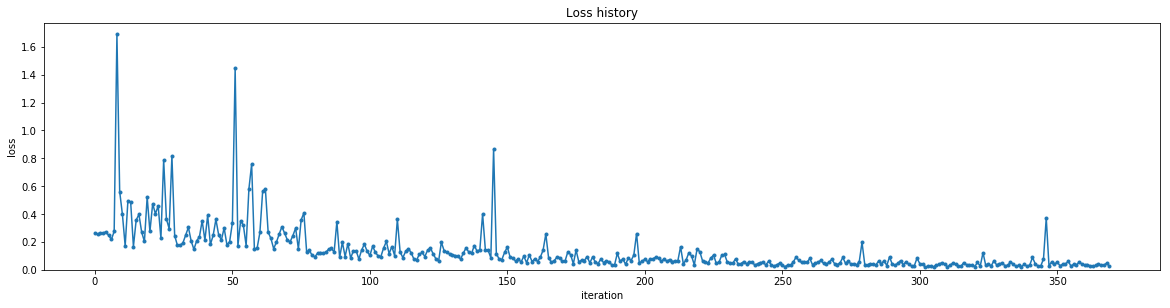

In [133]:
plot_loss(losses)

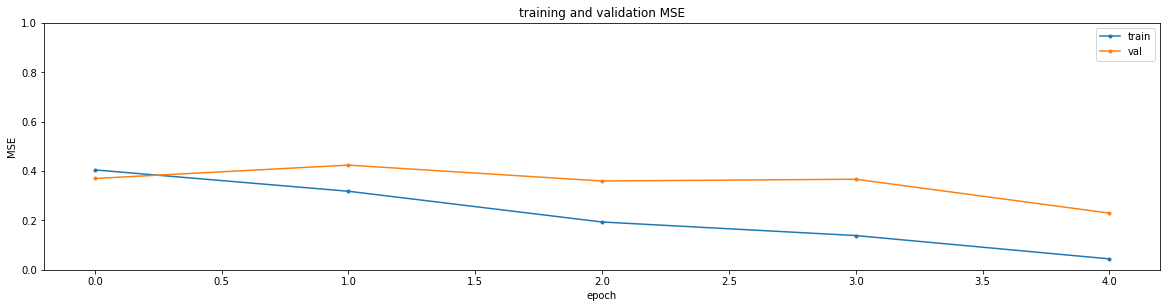

In [134]:
plot_accuracies(training_accuracy, validation_accuracy)

# pretrain for 3k

In [38]:
min_loss, best_val_mse, best_train_mse = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.0115
best training accuracy 0.0322
Best validation accuracy 0.5583


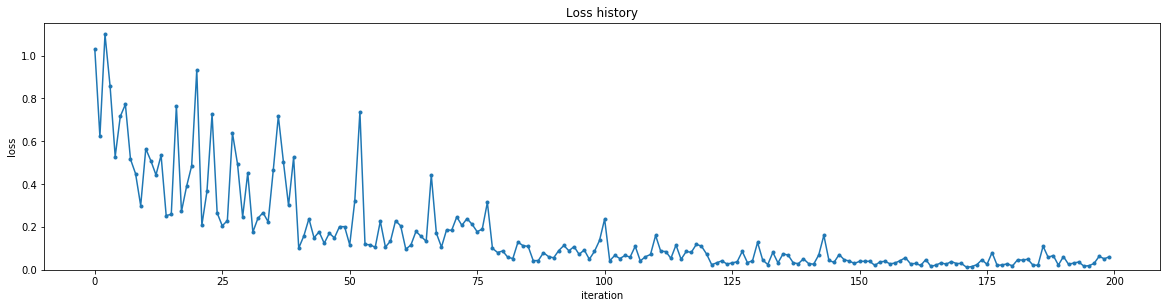

In [39]:
plot_loss(losses)

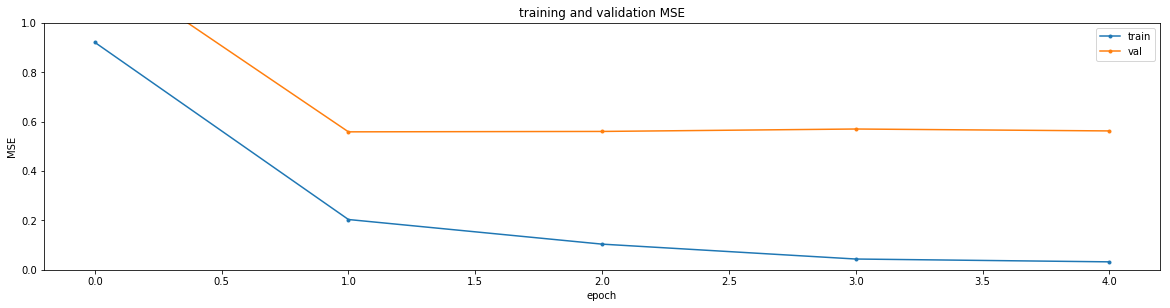

In [40]:
plot_accuracies(training_accuracy, validation_accuracy)

# plot prediction

In [46]:
# new_model = torch.load('regression_checkpoint.pth')['model']
# new_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [135]:
val_params = {'batch_size': NUM_VAL, # low for testing
          'shuffle': False, 'num_workers' : 2}
new_validation_generator = data.DataLoader(validation_set, **val_params)
with torch.no_grad():
    for x, y in new_validation_generator:
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=dtype)
        y_hat = model(x)

In [136]:
np_y = y.cpu().numpy()

In [137]:
np_y

array([[-8.63828003e-01],
       [ 4.57405001e-02],
       [-7.78577387e-01],
       [ 6.45931959e-01],
       [-7.01576889e-01],
       [ 2.12804094e-01],
       [-8.42515349e-01],
       [-5.20075738e-01],
       [-8.19140196e-01],
       [ 2.60875726e+00],
       [-5.46200871e-01],
       [-5.52388430e-01],
       [-4.63851057e-02],
       [-2.49198943e-01],
       [ 2.06616551e-01],
       [ 8.21933091e-01],
       [-9.16765809e-01],
       [ 1.66206360e+00],
       [-8.82390618e-01],
       [-8.80328059e-01],
       [-9.00953233e-01],
       [-5.70263565e-01],
       [-6.92639351e-01],
       [-9.26390886e-01],
       [ 9.22996283e-01],
       [-8.83765578e-01],
       [ 5.10493577e-01],
       [ 8.64558399e-01],
       [ 1.60843825e+00],
       [ 1.23512328e+00],
       [-3.18636894e-01],
       [-9.09890771e-01],
       [-9.33265924e-01],
       [-5.10450661e-01],
       [ 1.39874935e+00],
       [ 5.07056057e-01],
       [-8.70015502e-01],
       [ 5.55868864e-01],
       [ 2.7

In [138]:
np_prediction = y_hat.cpu().numpy()

In [139]:
np_prediction

array([[-6.58816576e-01],
       [ 4.33393754e-02],
       [-6.90718710e-01],
       [ 4.46078032e-01],
       [-3.99478674e-01],
       [ 3.86498779e-01],
       [-5.28117537e-01],
       [-1.77778304e-01],
       [-8.42633009e-01],
       [ 3.49885416e+00],
       [ 3.23184848e-01],
       [-1.20073460e-01],
       [ 3.04620862e-01],
       [ 7.69367069e-02],
       [-1.15243983e+00],
       [ 1.01154339e+00],
       [-6.62331641e-01],
       [ 1.57205856e+00],
       [-4.24493134e-01],
       [-6.64878786e-01],
       [-6.39456034e-01],
       [-4.14719015e-01],
       [-4.23235476e-01],
       [-8.54620337e-01],
       [ 1.07776153e+00],
       [-5.12612581e-01],
       [ 9.56915736e-01],
       [ 3.53485078e-01],
       [ 1.43804264e+00],
       [ 1.62481213e+00],
       [ 1.86246917e-01],
       [-6.34149551e-01],
       [-1.40778631e-01],
       [-6.56299412e-01],
       [ 1.08062172e+00],
       [ 7.32022822e-01],
       [-9.58208442e-01],
       [ 4.26145613e-01],
       [ 3.3

In [140]:
mean_squared_error(np_y,
                   np_prediction)

0.22928843

In [141]:
unnormalized_prediction = (np_prediction * y_std) + y_mean

In [142]:
validation_labels.shape

(913, 62)

In [143]:
unnormalized_prediction.shape

(913, 1)

In [144]:
val_set = validation_labels.copy()

In [145]:
val_set['original_size_prediction'] = unnormalized_prediction
val_set['prediction'] = np_prediction

In [146]:
validation_result = val_set[['well_id','well_label','hyst2_area_13',
       'normalized_hyst2_area_13', 'original_size_prediction', 'prediction']]

In [147]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_result['normalized_hyst2_area_13'],
                   validation_result['prediction'])

0.22928844064028048

In [148]:
validation_result

,well_id,well_label,hyst2_area_13,normalized_hyst2_area_13,original_size_prediction,prediction
0,304,304,192,-0.863828,490.196411,-0.658817
1,3240,3240,1515,0.045740,1511.507446,0.043339
2,65,65,316,-0.778577,443.793579,-0.690719
3,2006,2006,2388,0.645932,2097.305176,0.446078
4,2244,2244,428,-0.701577,867.412659,-0.399479
5,1170,1170,1758,0.212804,2010.645020,0.386499
6,2419,2419,223,-0.842515,680.302856,-0.528118
7,2121,2121,692,-0.520076,1189.883789,-0.177778
8,3472,3472,257,-0.819140,222.828857,-0.842633
9,2079,2079,5243,2.608757,6537.677734,3.498854


In [149]:
pred_truth_correlation = validation_result['hyst2_area_13'].corr(validation_result['original_size_prediction'])

In [150]:
pred_truth_correlation

0.8585351017797214

In [151]:
val_prediction = validation_result.set_index('hyst2_area_13')['original_size_prediction']

Text(0.5, 1.0, 'day13 size prediction and observation')

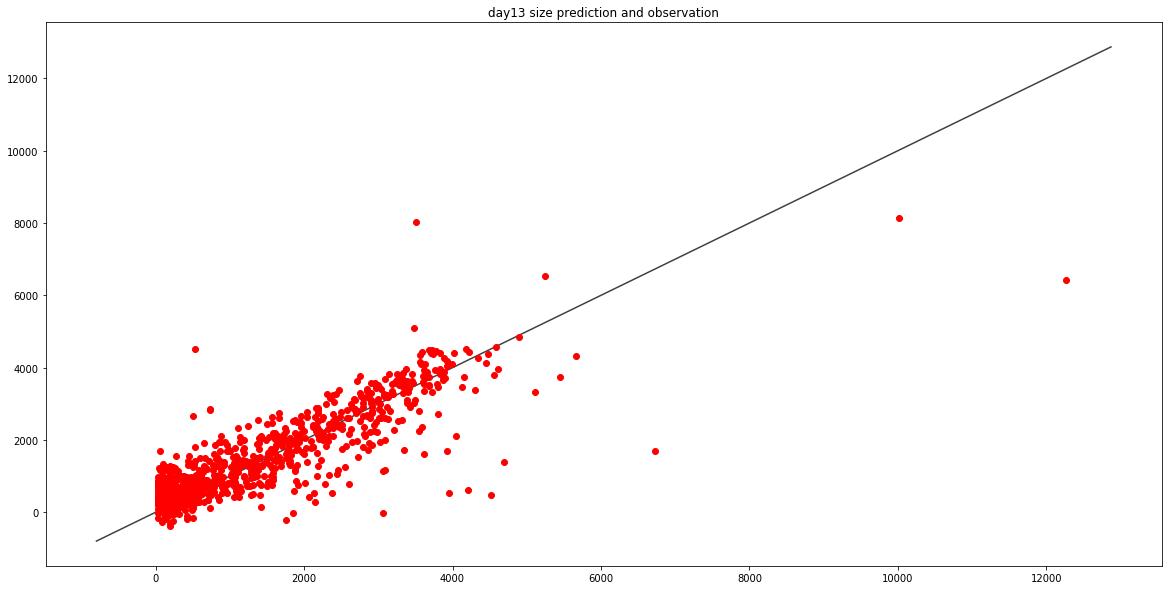

In [152]:
#fig = plt.figure()
fig, ax = plt.subplots( nrows=1, ncols=1 )
plt.plot(validation_result['hyst2_area_13'],validation_result['original_size_prediction'], 'o',color='r' )
#ax = validation_result.plot(kind='scatter', x='original_hyst2_area_13', y='original_size_prediction', color='r')  
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#plt.set_aspect('equal')
plt.title("day13 size prediction and observation")

In [497]:
validation_set

In [498]:

    #indexes = i.to(device=device, dtype=dtype)

In [499]:
validation_y

0      1.413712
1      1.848825
2     -0.671904
3      3.763604
4      0.153696
5      0.026788
6     -0.829494
7     -0.829494
8     -0.221450
9      0.808458
10    -0.916656
11     0.990452
12     1.283317
13    -0.584045
14    -0.941758
15    -0.820429
16    -1.000331
17     0.715020
18     0.035852
19     1.031593
20     1.049025
21     0.100004
22     1.002306
23    -0.866450
24    -0.827402
25    -0.717926
26     1.020436
27     1.010674
28    -0.941061
29    -0.440402
         ...   
446   -0.890158
447   -0.975229
448   -0.793234
449    0.398447
450    0.011447
451   -0.977321
452   -0.476661
453   -0.916656
454    0.425642
455    0.188561
456   -0.939667
457   -0.851807
458    0.643896
459    0.936063
460    0.783355
461    0.135566
462   -0.899223
463   -0.728385
464    1.346771
465    0.947917
466   -0.775802
467   -0.508737
468    0.572074
469   -0.892250
470   -0.190072
471    0.023301
472   -0.732569
473   -0.570796
474    6.474696
475   -0.447375
Name: normalized_hyst2_a

In [470]:
len(indexes)

0

In [500]:
y

tensor([[ 1.4137e+00],
        [ 1.8488e+00],
        [-6.7190e-01],
        [ 3.7636e+00],
        [ 1.5370e-01],
        [ 2.6788e-02],
        [-8.2949e-01],
        [-8.2949e-01],
        [-2.2145e-01],
        [ 8.0846e-01],
        [-9.1666e-01],
        [ 9.9045e-01],
        [ 1.2833e+00],
        [-5.8404e-01],
        [-9.4176e-01],
        [-8.2043e-01],
        [-1.0003e+00],
        [ 7.1502e-01],
        [ 3.5852e-02],
        [ 1.0316e+00],
        [ 1.0490e+00],
        [ 1.0000e-01],
        [ 1.0023e+00],
        [-8.6645e-01],
        [-8.2740e-01],
        [-7.1793e-01],
        [ 1.0204e+00],
        [ 1.0107e+00],
        [-9.4106e-01],
        [-4.4040e-01],
        [-3.3232e-01],
        [ 5.7696e-01],
        [-5.9032e-01],
        [-9.0968e-01],
        [-4.0414e-01],
        [ 3.8311e-01],
        [ 6.9131e-01],
        [-7.8626e-01],
        [ 9.3551e-03],
        [-8.7621e-01],
        [ 1.5085e+00],
        [-7.7441e-01],
        [ 9.6465e-01],
        [ 6

In [501]:
y_hat

tensor([[ 1.5595e+00],
        [-8.6820e-01],
        [-5.4880e-01],
        [ 1.4172e+00],
        [ 8.3298e-01],
        [-7.9306e-01],
        [-1.4648e-01],
        [-8.5228e-01],
        [ 2.6408e-01],
        [ 1.1353e+00],
        [-5.5413e-01],
        [ 1.0838e+00],
        [ 1.2885e+00],
        [-5.1470e-01],
        [-4.9065e-01],
        [-3.7118e-01],
        [-6.6284e-01],
        [ 1.9464e-01],
        [ 8.1778e-01],
        [ 1.0282e+00],
        [ 4.7550e-01],
        [ 1.0401e+00],
        [ 1.0658e+00],
        [-8.1743e-01],
        [-5.4959e-01],
        [-8.9191e-01],
        [ 5.1409e-01],
        [ 1.0540e+00],
        [-6.8063e-01],
        [-3.0010e-01],
        [-3.0973e-01],
        [ 6.0255e-01],
        [-7.8086e-01],
        [-7.8863e-01],
        [-6.7364e-01],
        [ 3.6129e-01],
        [ 7.6090e-01],
        [ 2.0642e-01],
        [ 2.9946e-01],
        [-7.1466e-01],
        [ 1.1700e+00],
        [-6.1372e-01],
        [ 7.4375e-01],
        [ 6